In [12]:
import numpy as np
import scipy.special as sps
import scipy.stats as spst
import sys,math
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

In [3]:
def step(q):
    k = len(q)-1
    a = np.diag((np.arange(k,dtype=float)+1)/k,1) + np.diag((k-np.arange(k,dtype=float))/k,-1) # - np.eye(k+1)
    return np.dot(a,q)

def iteratesteps(q,steps = 1):
    if steps <= 0:
        return q
    elif steps == 1:
        return step(q)
    else:
        return iteratesteps(step(q),steps - 1)

def binomdistr(k = 5):
    return sps.binom(k,np.arange(k+1))/2**k

def deltastart(i,k = 5):
    r = np.zeros(k+1)
    r[i] = 1.
    return r

def probflipping(i, steps, k = 5):
    q = deltastart(i,k)
    q = iteratesteps(q,steps)
    if i >= k/2:
        return np.sum(q[:k//2+1])
    else:
        return np.sum(q[k//2+1:])
    

In [4]:
q = binomdistr(4)
q = deltastart(1,6)
iteratesteps(q,10)

array([0.        , 0.19617606, 0.        , 0.62498942, 0.        ,
       0.17883453, 0.        ])

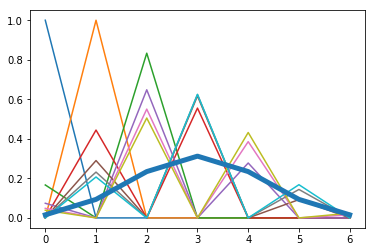

In [5]:
# ProbDistr of states iterated

q = deltastart(0,6)
maxsteps = 10
for i in range(maxsteps):
    plt.plot(q)
    q = step(q)
plt.plot(binomdistr(6),lw = 5)
plt.show()

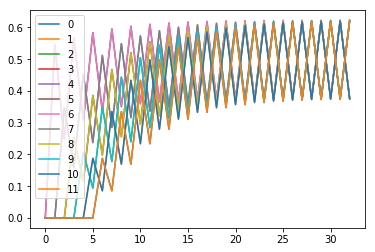

In [6]:
# Probability of flip depending on initial state

k = 11
lgnd = []
for i in range(k+1):
    p = np.array([probflipping(i,s,k) for s in range(3*k)])
    plt.plot(p)
    lgnd.append(i)
plt.legend(lgnd)
plt.show()

In [7]:
probflipping(1,21,5)

0.31248766046526516

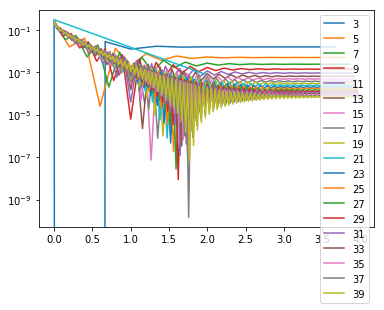

In [8]:
# Compute deviation from 0.5 for asymptotic value

#maxsteps = 20
lgnd = []
plt.yscale('log')
for k in np.arange(3,40,step = 2):
    totalprobflipperstep = np.array([np.dot(binomdistr(k),[probflipping(i,steps,k) for i in range(k+1)]) for steps in range(4*k)])
    plt.plot(np.arange(4*k,dtype=float)/k,(.5-totalprobflipperstep)**2)
    lgnd.append(k)

    
x = np.arange(start = 0, stop = 2, step = .02)
plt.plot(x,.3*np.exp(-3*x))
plt.legend(lgnd)
plt.show()

In [9]:
deviation = []
klist = []
for k in np.arange(3,100,step = 2):
    totalprobflipperstep = [-0.5 + np.dot(binomdistr(k),[probflipping(i,5*k,k) for i in range(k+1)]),0.5 - np.dot(binomdistr(k),[probflipping(i,5*k+1,k) for i in range(k+1)])]
    deviation.append(np.mean(totalprobflipperstep))
    klist.append(k)


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/lib64/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


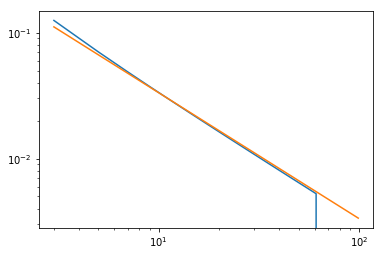

In [10]:

plt.xscale('log')
plt.yscale('log')
plt.plot(klist,deviation)
plt.plot(klist,[.3333/k for k in klist])

In [11]:
def LMSQ(x,y):
    n   = len(x)
    sx  = np.sum(x)
    sy  = np.sum(y)
    sxx = np.dot(x,x)
    sxy = np.dot(x,y)
    syy = np.dot(y,y)
    
    denom  = (n*sxx-sx*sx)
    b      = (n*sxy - sx*sy)/denom
    a      = (sy-b*sx)/n
    estim  = np.array([a,b],dtype=np.float)

    sigma2 = syy + n*a*a + b*b*sxx + 2*a*b*sx - 2*a*sy - 2*b*sxy
    cov    = sigma2 / denom * np.array([[sxx,-sx],[-sx,n]],dtype=np.float)

    return estim,cov

[-0.99209428 -1.03838656]


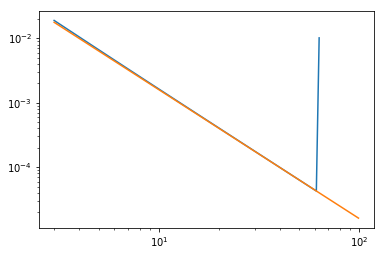

In [12]:
fit,cov = LMSQ(np.log(klist[:30]),np.log(deviation[:30]))
print(fit)

plt.plot(klist,abs(deviation-np.power(klist,-1.)/math.pi))
plt.plot(klist,np.power(klist,-2.)/(2*math.pi))
#plt.plot(klist,np.exp(fit[0] + fit[1] * np.log(klist)))
plt.yscale('log')
plt.xscale('log')

In [13]:
maxsteps = 20
lgnd = []
#plt.yscale('log')
#plt.xscale('log')

totalpf = list()

for k in np.arange(3,50,step = 2):
    totalprobflipperstep = np.array([np.dot(binomdistr(k),[probflipping(i,steps,k) for i in range(k+1)]) for steps in range(3*k)])
    totalpf.append(np.array([np.arange(3*k,dtype=float)/k,totalprobflipperstep]))
    #plt.plot(np.arange(3*k,dtype=float)/k,totalprobflipperstep)
    #lgnd.append(k)

    
#x = np.arange(start = 0, stop = 3, step = .02)
#plt.plot(x,1-exp(-x))
#plt.legend(lgnd)
#plt.show()

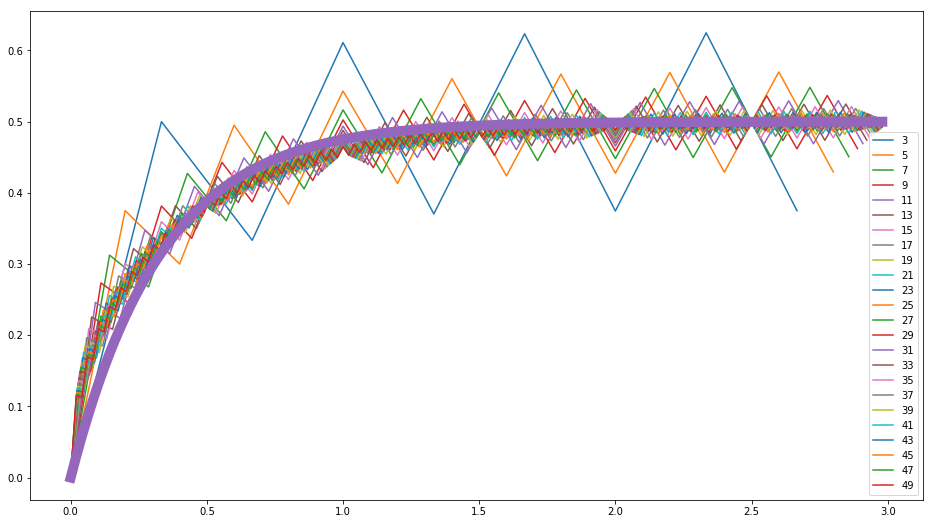

In [31]:
lgnd=[]
for x in totalpf:
    plt.plot(x[0],x[1])
    lgnd.append(int(1/x[0][1]))

x = np.arange(start = 0, stop = 3, step = .02)
plt.plot(x,.5*(1-np.exp(-3.0*x)), lw = 10)
plt.legend(lgnd)
plt.show()

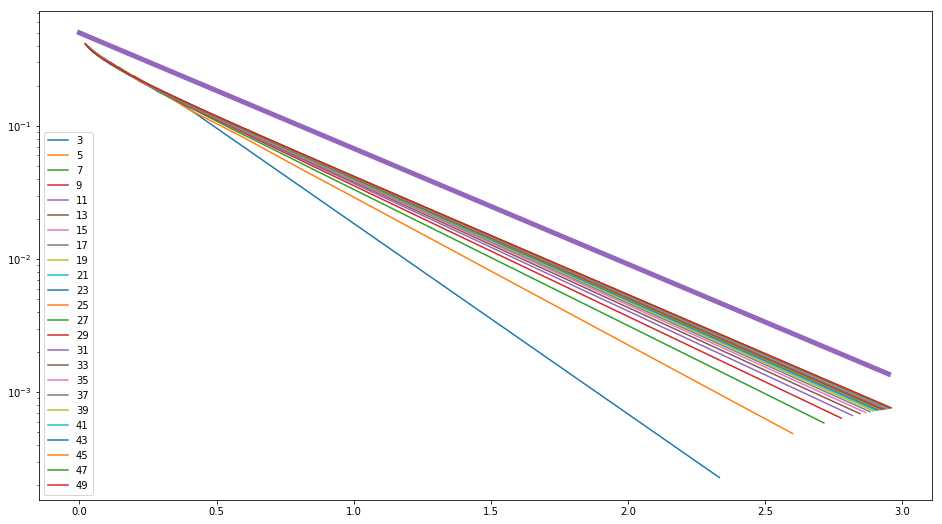

In [29]:
# interpolate approach to asymptotic form by smearing out the oscillating signal
# set smeared[i] ~ 0.25 * x[i-1] + 0.50 * x[i] + 0.25 * x[i+1]
# this should get rid of oscillating, while still keeping overall dynamics more or less conserved

lgnd = []
for x in totalpf:
    smeared = np.zeros(len(x[1]))
    for i in range(1,len(x[1])-1):
        smeared[i] = 0.5 * (0.5 * x[1][i-1] + x[1][i] + 0.5 * x[1][i+1])
    plt.plot(x[0][1:-1],0.5-smeared[1:-1])
    lgnd.append(int(1/x[0][1]))
plt.yscale('log')    
#plt.xscale('log')

y = np.arange(start = 0, stop = 3, step = .05)
plt.plot(y,np.exp(-2*y)*.5,lw = 5)
plt.legend(lgnd)
plt.show()

In [17]:
q = deltastart(4)
for s in range(10):
    print('sum = {:.1f};    {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(np.sum(q),*q))
    q = step(q)

sum = 1.0;    0.000 0.000 0.000 0.000 1.000
sum = 1.0;    0.000 0.000 0.000 0.800 0.000
sum = 1.0;    0.000 0.000 0.480 0.000 0.520
sum = 1.0;    0.000 0.192 0.000 0.704 0.000
sum = 1.0;    0.038 0.000 0.576 0.000 0.386
sum = 1.0;    0.000 0.269 0.000 0.654 0.000
sum = 1.0;    0.054 0.000 0.607 0.000 0.339
sum = 1.0;    0.000 0.297 0.000 0.635 0.000
sum = 1.0;    0.059 0.000 0.619 0.000 0.322
sum = 1.0;    0.000 0.307 0.000 0.629 0.000


In [18]:
k = 4
a = np.diag((np.arange(k,dtype=float)+1)/k,1) + np.diag((k-np.arange(k,dtype=float))/k,-1) # - np.eye(k+1)
q = deltastart(3,k=k)
print(q)
print(a*a*a*a*a)
q = np.dot(a,np.dot(a,q))
print('sum = {:.1f};    {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(np.sum(q),*q))
q = np.dot(a,q)
print('sum = {:.1f};    {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(np.sum(q),*q))
q = np.dot(a,q)
print('sum = {:.1f};    {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(np.sum(q),*q))
q = np.dot(a,q)
print('sum = {:.1f};    {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(np.sum(q),*q))


[0. 0. 0. 1. 0.]
[[0.00000000e+00 9.76562500e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 3.12500000e-02 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.37304688e-01 0.00000000e+00 2.37304688e-01
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.12500000e-02 0.00000000e+00
  1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.76562500e-04
  0.00000000e+00]]
sum = 1.0;    0.000 0.375 0.000 0.625 0.000
sum = 1.0;    0.094 0.000 0.750 0.000 0.156
sum = 1.0;    0.000 0.469 0.000 0.531 0.000
sum = 1.0;    0.117 0.000 0.750 0.000 0.133


In [32]:
# evaluate generating function with SymPy (symbolic python)
import sympy

def genfunc(x,y,z,a0 = 5,b0 = 0):
    return (x * sympy.cosh(z) + y * sympy.sinh(z))**a0 * (x * sympy.sinh(z) + y * sympy.cosh(z))**b0

def ProbGF(t = 0, k = 5, a0 = 0):
    x,y,z = sympy.symbols('x y z')
    expr = genfunc(x,y,z,a0,k - a0)
    expr = sympy.diff(expr,z,t).subs(z,0)
    r = np.ones(k+1) / (k ** t)
    for i in range(k+1):
        tmp = sympy.diff(expr,x,i).subs(x,0)/math.factorial(i)
        tmp = sympy.diff(tmp,y,k-i).subs(y,0)/math.factorial(k-i)
        r[i] *= tmp
    return r

In [33]:
print(ProbGF(t = 2, a0 = 2))
print(iteratesteps(deltastart(2,k=5),2))

[0.08 0.   0.68 0.   0.24 0.  ]
[0.08 0.   0.68 0.   0.24 0.  ]


In [34]:
q = deltastart(3,k = 5)
print(iteratesteps(q,3))

[0.048 0.    0.6   0.    0.352 0.   ]


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


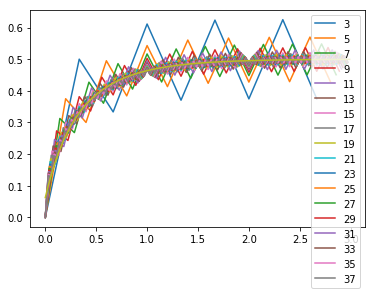

In [15]:
#flips = []
#lgnd = []
for k in np.arange(start = 3, stop = 39, step = 2, dtype = np.int):
    k2 = int((k+1)/2)
    print(k2)
    #tmp = np.array([np.dot(2*binomdistr(k)[:k2],[probflipping(i,s,k) for i in range(k2)]) for s in range(3*k)])
    #flips.append((np.arange(0,3,step = 1./k),tmp))
    #lgnd.append(k)
    plt.plot(flips[k2-2][0],flips[k2-2][1])
    
plt.legend(lgnd)

y = np.arange(start = 0, stop = 3, step = .01)

plt.plot(y,.5*(1-0.5*np.exp(-2*y)-0.25*np.exp(-4*y)-0.125*np.exp(-6*y)))
plt.show()



In [14]:
def Psflip(step, r = .1, K = 5):
    return 0.5*(1.-np.exp(-2.*r*step/K))

def Pxflip(step, r = .1, K = 5):
    if isinstance(step,(list,tuple,np.ndarray)):
        return np.array([r * Psflip(s, r ,K) * np.prod([1-r+r*(1-Psflip(i, r, K)) for i in np.arange(1,s)]) for s in step])
    else:
        return r * Psflip(step, r ,K) * np.prod([1-r+r*(1-Psflip(i, r, K)) for i in np.arange(1,step)])
    
def Poiss(k,mu):
    if isinstance(k,(list,tuple,np.ndarray)):
        return np.array([mu**kk/math.factorial(kk)*np.exp(-mu) for kk in k])
    else:
        return mu**k/math.factorial(k)*np.exp(-mu)

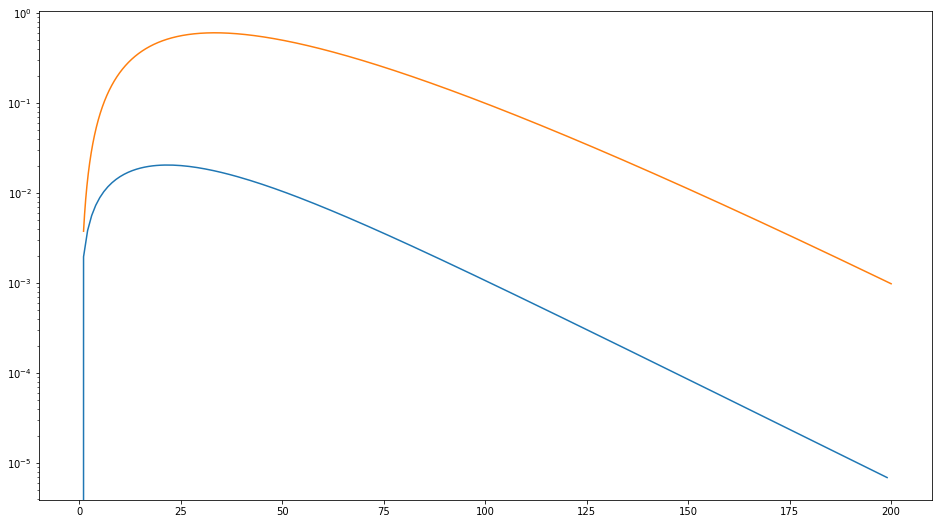

7.805137989258526e-07


In [100]:
plt.plot(Pxflip(np.arange(200)))
plt.yscale('log')

#plt.plot(Poiss(np.arange(100),20.))

xx = np.arange(start = 1, stop = 200, step = .01)
plt.plot(xx,xx**2*np.exp(-.06*xx)*4e-3)

plt.show()


print(1-np.sum(Pxflip(np.arange(300))))

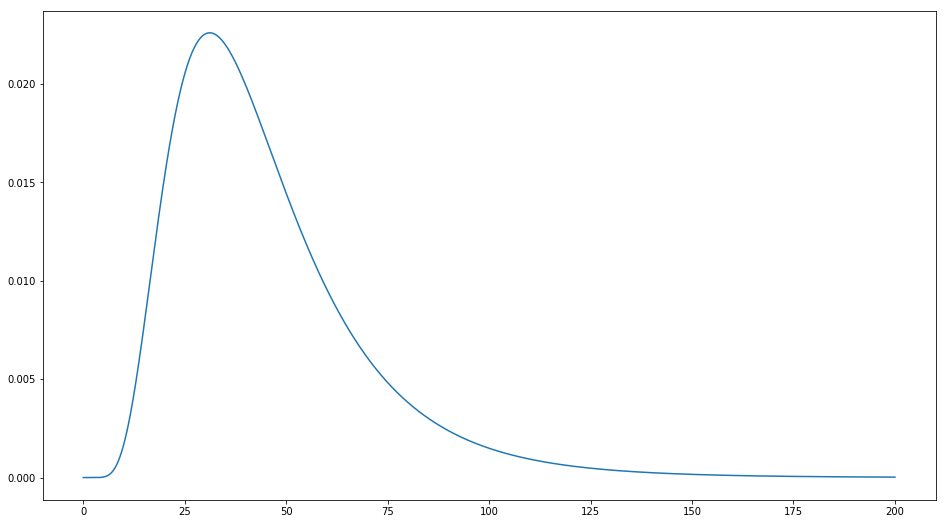

In [74]:
xx = np.arange(start = 0, stop = 200, step = .01)
plt.plot(xx,spst.lognorm.pdf(xx,.5,scale=40))
plt.show()

In [86]:
pxf = Pxflip(np.arange(200))

n = np.arange(200)

print([np.dot(n**i,pxf) for i in range(5)])

print(np.dot(n*n,pxf) - np.dot(n,pxf)**2)


[0.9998682264993259, 36.59446821860343, 1916.9254864477964, 130634.18062899081, 10950434.19389665]
577.7703822454198


In [108]:
def xexp(xx,p1,p2):
    return np.power(xx,p1)*np.exp(-p2 *xx)/(math.gamma(p1+1.)*np.power(p2,-p1-1))

def lxexp(xx,p1,p2):
    return p1 * np.log(xx) - p2 * xx - math.lgamma(p1+1.) + (p1+1)*np.log(p2)

from scipy.optimize import curve_fit

x = np.arange(1,200)
pxf = Pxflip(x)

p0 = [1,.05]

fit,cov = curve_fit(lxexp,x,np.log(pxf),p0=p0,maxfev=5000)
print(fit,cov)

[1.19547494 0.06054007] [[4.74039064e-05 7.08085587e-07]
 [7.08085587e-07 1.18315329e-08]]


In [1]:
plt.plot(x,pxf)
plt.plot(x,xexp(x,1.19,.0605))
plt.show()

NameError: name 'plt' is not defined

In [16]:
a = np.arange(200)
pxf = Pxflip(a)

np.savetxt('fliphisto.txt',np.array([a,pxf]).T)

In [4]:
b = np.zeros(20)

b[::2] = .6
b[1::2] = .4

print(b)
for i in range(len(b)):
    print(np.prod(b[:i]))

[0.6 0.4 0.6 0.4 0.6 0.4 0.6 0.4 0.6 0.4 0.6 0.4 0.6 0.4 0.6 0.4 0.6 0.4
 0.6 0.4]
1.0
0.6
0.24
0.144
0.0576
0.03456
0.013824000000000001
0.0082944
0.0033177600000000003
0.001990656
0.0007962624
0.00047775743999999996
0.000191102976
0.00011466178559999999
4.5864714239999996e-05
2.7518828543999997e-05
1.10075314176e-05
6.60451885056e-06
2.641807540224e-06
1.5850845241344e-06


In [11]:
c = np.arange(start=0.1,stop=1,step=.1)
print(c)
for i in range(len(c)):
    print(np.prod(c[:i]))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
1.0
0.1
0.020000000000000004
0.006000000000000002
0.002400000000000001
0.0012000000000000005
0.0007200000000000003
0.0005040000000000002
0.0004032000000000002


In [12]:
test = np.array([0.,         0.66666667, 0.22222222, 0.74074074, 0.24691358, 0.74897119, 0.24965706, 0.74988569, 0.2499619,  0.7499873,  0.24999577, 0.74999859,0.24999953, 0.74999984, 0.24999995, 0.74999998, 0.24999999, 0.75, 0.25,       0.75      ])

In [13]:
print(test)

[0.         0.66666667 0.22222222 0.74074074 0.24691358 0.74897119
 0.24965706 0.74988569 0.2499619  0.7499873  0.24999577 0.74999859
 0.24999953 0.74999984 0.24999995 0.74999998 0.24999999 0.75
 0.25       0.75      ]


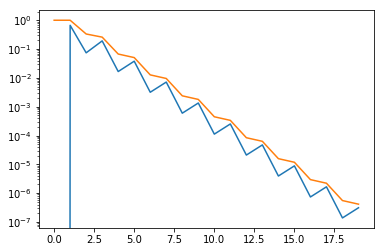

In [21]:
a=np.zeros(len(test))
for i in range(len(test)):
    a[i] = np.prod(1-test[:i])
plt.yscale('log')
plt.plot(a*test)
plt.plot(a)
plt.show()

In [3]:
data = np.genfromtxt('data/histo.K05')
Pxn = data[:,1]
Psn = data[:,2]

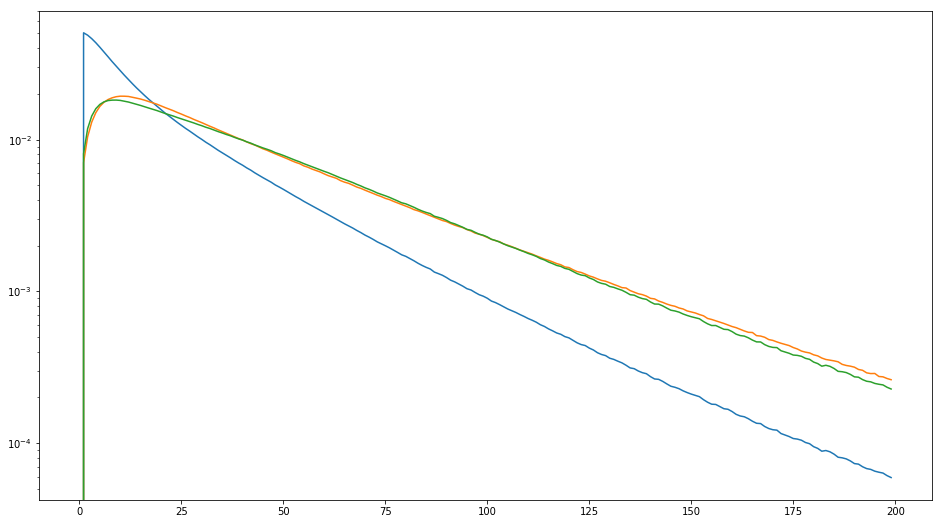

In [19]:
plt.yscale('log')
plt.plot(Psn[:200])
plt.plot(Pxn[:200])
plt.plot(Psn[:200]*np.arange(200)**.6*.16)
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


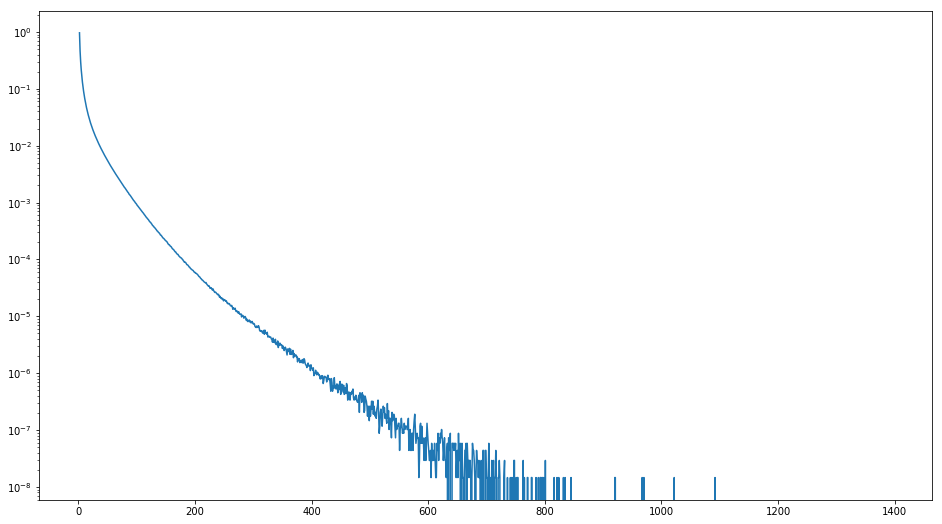

In [33]:
plt.yscale('log')
Pn = np.array([np.sum(Psn[:i]) for i in range(len(Psn))])
plt.plot(Psn/Pn)
plt.show()

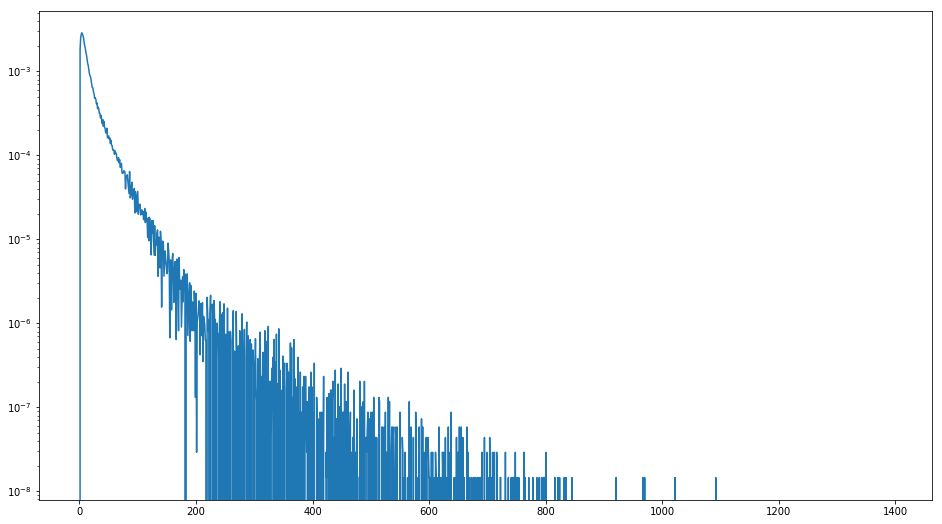

In [9]:
plt.yscale('log')
plt.plot(-np.diff(Psn)[:])
plt.
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


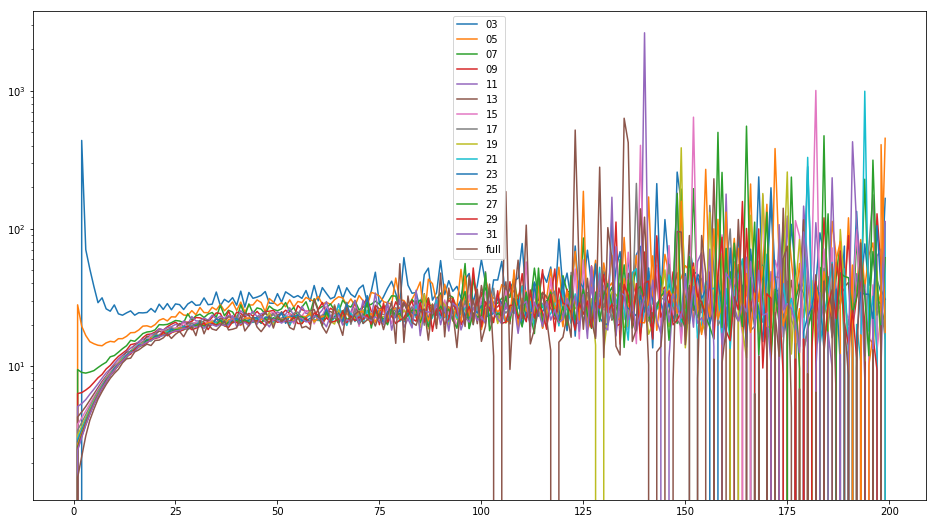

In [43]:
datadir = 'data/'
lgnd = list()
Psn = dict()
Pxn = dict()
for fn in [fn for fn in os.listdir(datadir) if fn.startswith('histo.')]:
    K = fn[7:]
    #print(fn,K)
    tmpdata = np.genfromtxt(datadir + fn)

    Psn[K] = tmpdata[:,2]
    Pxn[K] = tmpdata[:,1]
    lgnd.append(K)
    #lgnd.append(K)
    #lgnd.append(K)
    #plt.plot(-np.diff(Psn[K])[:200])
lgnd.sort()
for K in lgnd:
    plt.plot(1./((-np.diff(Psn[K])[:200])/Psn[K][:200]))
    #plt.plot(Psn[K][:200],c='b')
    #plt.plot(Pxn[K][:200],c='g')
plt.yscale('log')
plt.legend(lgnd)
plt.show()
    

In [39]:
os.name

'posix'